<a href="https://colab.research.google.com/github/aliFrancis/SEnSeIv2/blob/main/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SEnSeIv2 Demo

Welcome to this short notebook that will provide some example use-cases for SEnSeIv2, a sensor independent cloud masking model described in [this paper](https://ieeexplore.ieee.org/document/10505181).

This covers how to use SEnSeI-v2 models in Python. For the command-line tool, which handles the reading and preprocessing of Sentinel-2 and Landsat 8/9 imagery, please see the [GitHub](https://github.com/aliFrancis/SEnSeIv2/tree/main) readme.

The notebook demonstrates how to use the `senseiv2.inference.CloudMask` class to predict clouds across images. This class is a wrapper for the actual pytorch model, controlling things like the sliding window for predictions over images larger than the FOV of the model, and the desired output class structure.

If you'd like to experiment with lower-level operations using the pytorch model itself, you can use `senseiv2.utils.get_model_files` and `senseiv2.models.load_model` to instantiate the pretrained model.

The example shown here uses [Major TOM Core-S2L1C](https://huggingface.co/datasets/Major-TOM/Core-S2L1C) as a quick source of example imagery. Some simple preprocessing must be done (renormalisation of value range, and interpolation of lower resolution bands).

In [1]:
# %%capture
#@title Installation and Imports
%load_ext autoreload
%autoreload 2
!pip install leafmap datasets git+https://github.com/ESA-PhiLab/Major-TOM.git git+https://github.com/aliFrancis/SEnSeIv2.git@refactor-inference

from senseiv2.inference import CloudMask
from senseiv2.utils import get_model_files
from senseiv2.constants import SENTINEL2_BANDS,SENTINEL2_DESCRIPTORS,LANDSAT89_BANDS,LANDSAT89_DESCRIPTORS
from skimage import transform
import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path
import urllib.request
from majortom import *

  Cloning https://github.com/ESA-PhiLab/Major-TOM.git to /tmp/pip-req-build-_rrjdeap
  Running command git clone --filter=blob:none --quiet https://github.com/ESA-PhiLab/Major-TOM.git /tmp/pip-req-build-_rrjdeap
  Resolved https://github.com/ESA-PhiLab/Major-TOM.git to commit f57f47d5fde1beca49ca04b5ca74d613610fc7ee
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/aliFrancis/SEnSeIv2.git (to revision refactor-inference) to /tmp/pip-req-build-zc2wu04s
  Running command git clone --filter=blob:none --quiet https://github.com/aliFrancis/SEnSeIv2.git /tmp/pip-req-build-zc2wu04s
  Running command git checkout -b refactor-inference --track origin/refactor-inference
  Switched to a new branch 'refactor-inference'
  Branch 'refactor-inference' set up to track remote branch 'refactor-inference' from 'origin'.
  Resolved https://github.com/aliFrancis/SEnSeIv2.git to commit 1181c99fe2c2054ed6c086989395347d22facc4a
  Installing build dependencies ... done
  Getting requirement

In [2]:
#@title Create the SEnSeI-v2 + SegFormer cloud mask

# Set based on your runtime (cpu-only will run but is significantly slower)
DEVICE = 'cpu' #'cpu'/'cuda'

# Pick pre-trained model from https://huggingface.co/aliFrancis/SEnSeIv2
model_name = 'SEnSeIv2-SegFormerB2-alldata-ambiguous'
config, weights = get_model_files(model_name)

# Lots of options in the kwargs for different settings
model = CloudMask(config, weights, verbose=True, categorise=True, device=DEVICE)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
#@title Download some Sentinel-2 examples from Major TOM

SOURCE_DATASET = 'Major-TOM/Core-S2L1C' # Identify HF Dataset
DATASET_DIR = Path('./data/Major-TOM/')
DATASET_DIR.mkdir(exist_ok=True, parents=True)
ACCESS_URL = 'https://huggingface.co/datasets/{}/resolve/main/metadata.parquet?download=true'.format(SOURCE_DATASET)
LOCAL_URL = DATASET_DIR / '{}.parquet'.format(ACCESS_URL.split('.parquet')[0].split('/')[-1])

# download from server to local url
print('Downloading Major TOM Core-S2L1C metadata')
gdf = metadata_from_url(ACCESS_URL, LOCAL_URL)

# Randomly sample a few Major TOM images (with >5% cloud cover so that there are interesting masks)
cloudy = gdf[(gdf['cloud_cover']>5) & (gdf['nodata']==0)]
np.random.seed(157)
samples = cloudy.sample(4)

# Download the samples
print('Downloading random sample')
filter_download(samples, local_dir='./data/', source_name='L1C', by_row=True)

# We will use all bands
band_names = [b['name'] for b in SENTINEL2_BANDS]

# Create a dataset object
ds = MajorTOM(samples, './data/L1C',tif_bands=band_names,tif_transforms=None)


In [4]:
#@title Predict the cloud masks


def preprocess_majortom(sample,bands):
  # Convert band tifs to all 10m resolution, TOA reflectance with 0-1 scale
  im = np.zeros((len(bands),1068,1068))
  for i,b in enumerate(bands):
    im[i,...] = transform.resize(
        sample[b][0],
        (1068,1068),
        order=1,
        preserve_range=True
    )
  if int(sample['meta']['product_id'].split('_')[3][2])>=4:
    im = im - 1000
  im = im / 10_000
  return im


# Print some useful info about SEnSeI-v2 inputs
im = preprocess_majortom(ds[0],band_names)
print(f'''
    SEnSeI-v2 input data structure, using Sentinel-2 as example:
      ---------------------------------------
      senseiv2_model(im,descriptors,**kwargs)
      ---------------------------------------
        im: C-by-X-by-Y, C is the number of channels... e.g. {im.shape}
              where interpolation is used to make each band the same resolution

        descriptors: list of length C, for each band's descriptor... for Sentinel-2, this would be:
            {SENTINEL2_DESCRIPTORS[0]},
            {SENTINEL2_DESCRIPTORS[1]},
            ...
            {SENTINEL2_DESCRIPTORS[-1]}

    For more examples of descriptor vectors, see senseiv2.constants
''')

# Actually calculate the cloud masks!
cloud_masks = []
for i in range(4):
  im = preprocess_majortom(ds[i],band_names) # im is a 13-channel numpy array
  cloud_mask = model(im,descriptors=SENTINEL2_DESCRIPTORS,stride=357)
  cloud_masks.append(cloud_mask)


    SEnSeI-v2 input data structure, using Sentinel-2 as example:
      ---------------------------------------
      senseiv2_model(im,descriptors,**kwargs)
      ---------------------------------------
        im: C-by-X-by-Y, C is the number of channels... e.g. (13, 1068, 1068)
              where interpolation is used to make each band the same resolution

        descriptors: list of length C, for each band's descriptor... for Sentinel-2, this would be:
            {'band_type': 'TOA Reflectance', 'min_wavelength': 425.0, 'max_wavelength': 461.0},
            {'band_type': 'TOA Reflectance', 'min_wavelength': 446.0, 'max_wavelength': 542.0},
            ...
            {'band_type': 'TOA Reflectance', 'min_wavelength': 2074.0, 'max_wavelength': 2314.0}
    
    For more examples of descriptor vectors, see senseiv2.constants



Predicting patches: 100%|██████████| 9/9 [01:10<00:00,  7.78s/it]


Postprocessing mask with classes: Clear/Thick/Thin/Shadow


Predicting patches: 100%|██████████| 9/9 [01:06<00:00,  7.38s/it]


Postprocessing mask with classes: Clear/Thick/Thin/Shadow


Predicting patches: 100%|██████████| 9/9 [01:05<00:00,  7.33s/it]


Postprocessing mask with classes: Clear/Thick/Thin/Shadow


Predicting patches: 100%|██████████| 9/9 [01:03<00:00,  7.06s/it]

Postprocessing mask with classes: Clear/Thick/Thin/Shadow


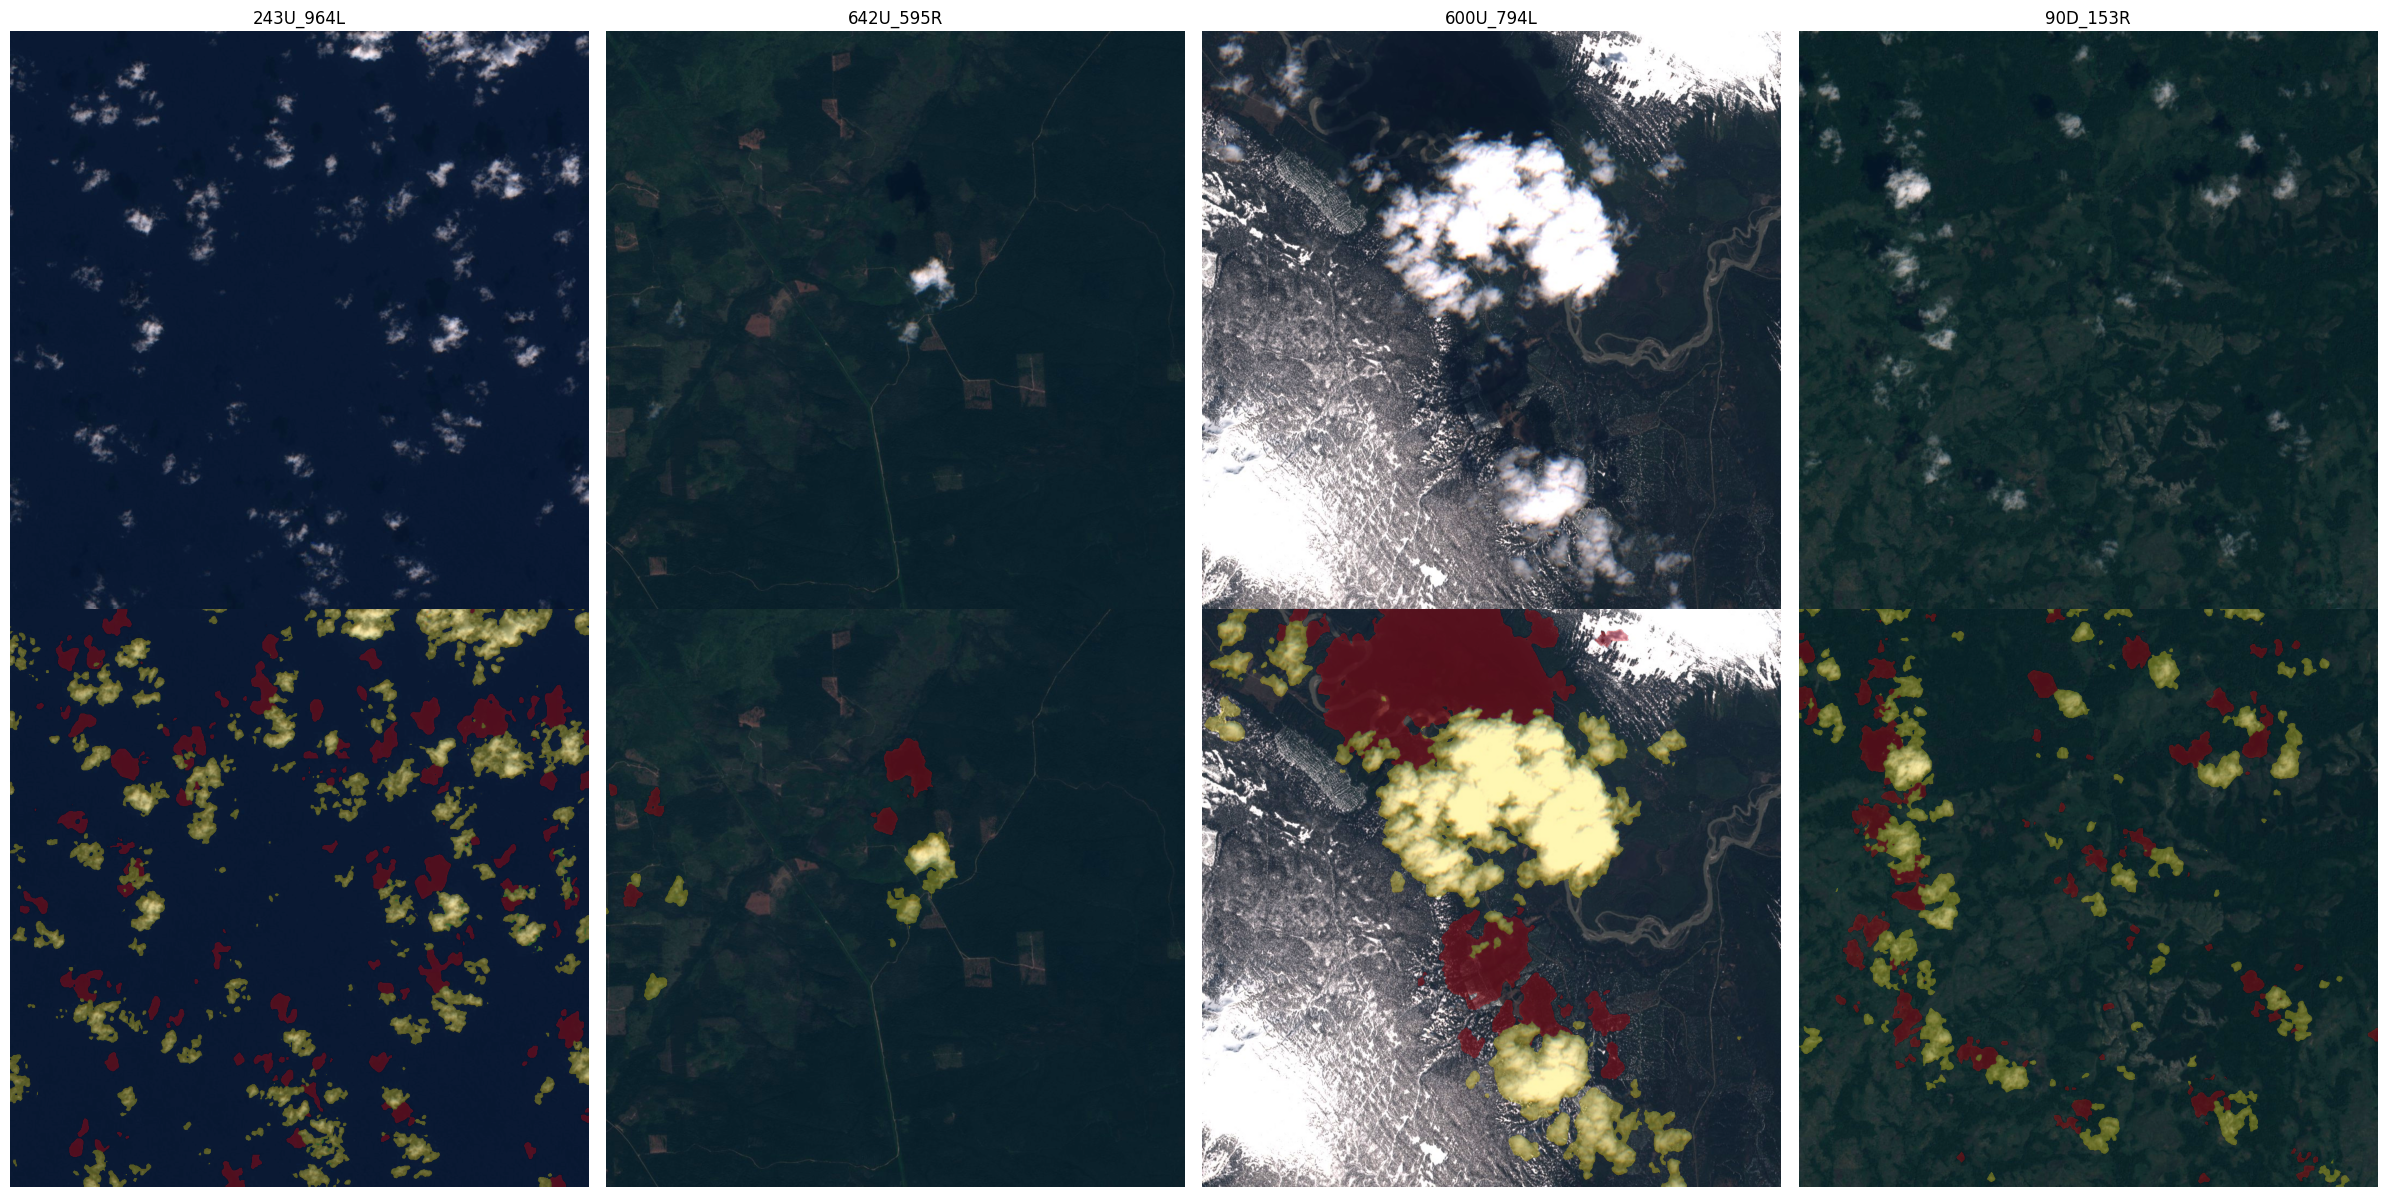

In [6]:
#@title Plot the masks

def convert_to_colormap(mask,style='4-class',categorised=True):

  if not categorised:
    mask = np.argmax(mask,axis=0)

  if style=='cloud-noncloud':
    out = np.zeros((mask.shape[0],mask.shape[1],4))
    out[mask==1] = [1,1,0,0.3] # Cloud

  if style=='4-class':
    # Convert to nice colours
    out = np.zeros((mask.shape[0],mask.shape[1],4))
    out[mask==1] = [1,0.9,0,0.3] # Thick
    out[mask==2] = [0.5,1,0.1,0.3] # Thin
    out[mask==3] = [1,0,0,0.3] # Shadow

  if style=='7-class':
    # Convert to nice colours
    out = np.zeros((mask.shape[0],mask.shape[1],4))
    out[mask==1] = [0,0,1,0.3] # Water
    out[mask==2] = [1,0,1,0.3] # Snow
    out[mask==3] = [0.5,1,0.1,0.3] # Thin
    out[mask==4] = [1,0.9,0,0.3] # Thick
    out[mask==5] = [1,0,0,0.3] # Shadow
  return out



def plot_masks(ds,masks,convert=True,categorised=True):
  fig,ax = plt.subplots(2,len(ds),figsize=(6*len(ds),12))
  for i in range(len(ds)):
    thumb = ds[i]['thumbnail'].moveaxis(0,-1)
    thumb = (thumb-thumb.min())/(thumb.max()-thumb.min())

    ax[0,i].imshow(thumb)
    ax[1,i].imshow(thumb)
    if convert:
      mask = convert_to_colormap(masks[i],categorised=categorised)
    else:
      mask = masks[i]
    ax[1,i].imshow(mask)

    ax[0,i].axis('off')
    ax[1,i].axis('off')

    ax[0,i].set_title(ds[i]['meta']['grid_cell'])

  fig.tight_layout()

plot_masks(ds, cloud_masks)

Running with different settings (always same pretrained weights):

1. Only RGB bands (B02,B03,B04) - we can use the same model class for this


Predicting patches: 100%|██████████| 9/9 [00:41<00:00,  4.63s/it]


Postprocessing mask with classes: Clear/Thick/Thin/Shadow

2. All bands, 7-class outputs - needs a new CloudMask object for different output style


Predicting patches: 100%|██████████| 9/9 [01:05<00:00,  7.24s/it]



3. cloud-noncloud outputs  - needs a new CloudMask object for different output style


Predicting patches: 100%|██████████| 9/9 [01:05<00:00,  7.24s/it]


Postprocessing mask with classes: Non-cloud/Cloud

4. A few different input bands, valid-invalid classes, retaining original confidence values  - needs a new CloudMask object for different output style


Predicting patches: 100%|██████████| 9/9 [00:45<00:00,  5.09s/it]


Postprocessing mask with classes: Valid/Invalid(cloud+shadow)


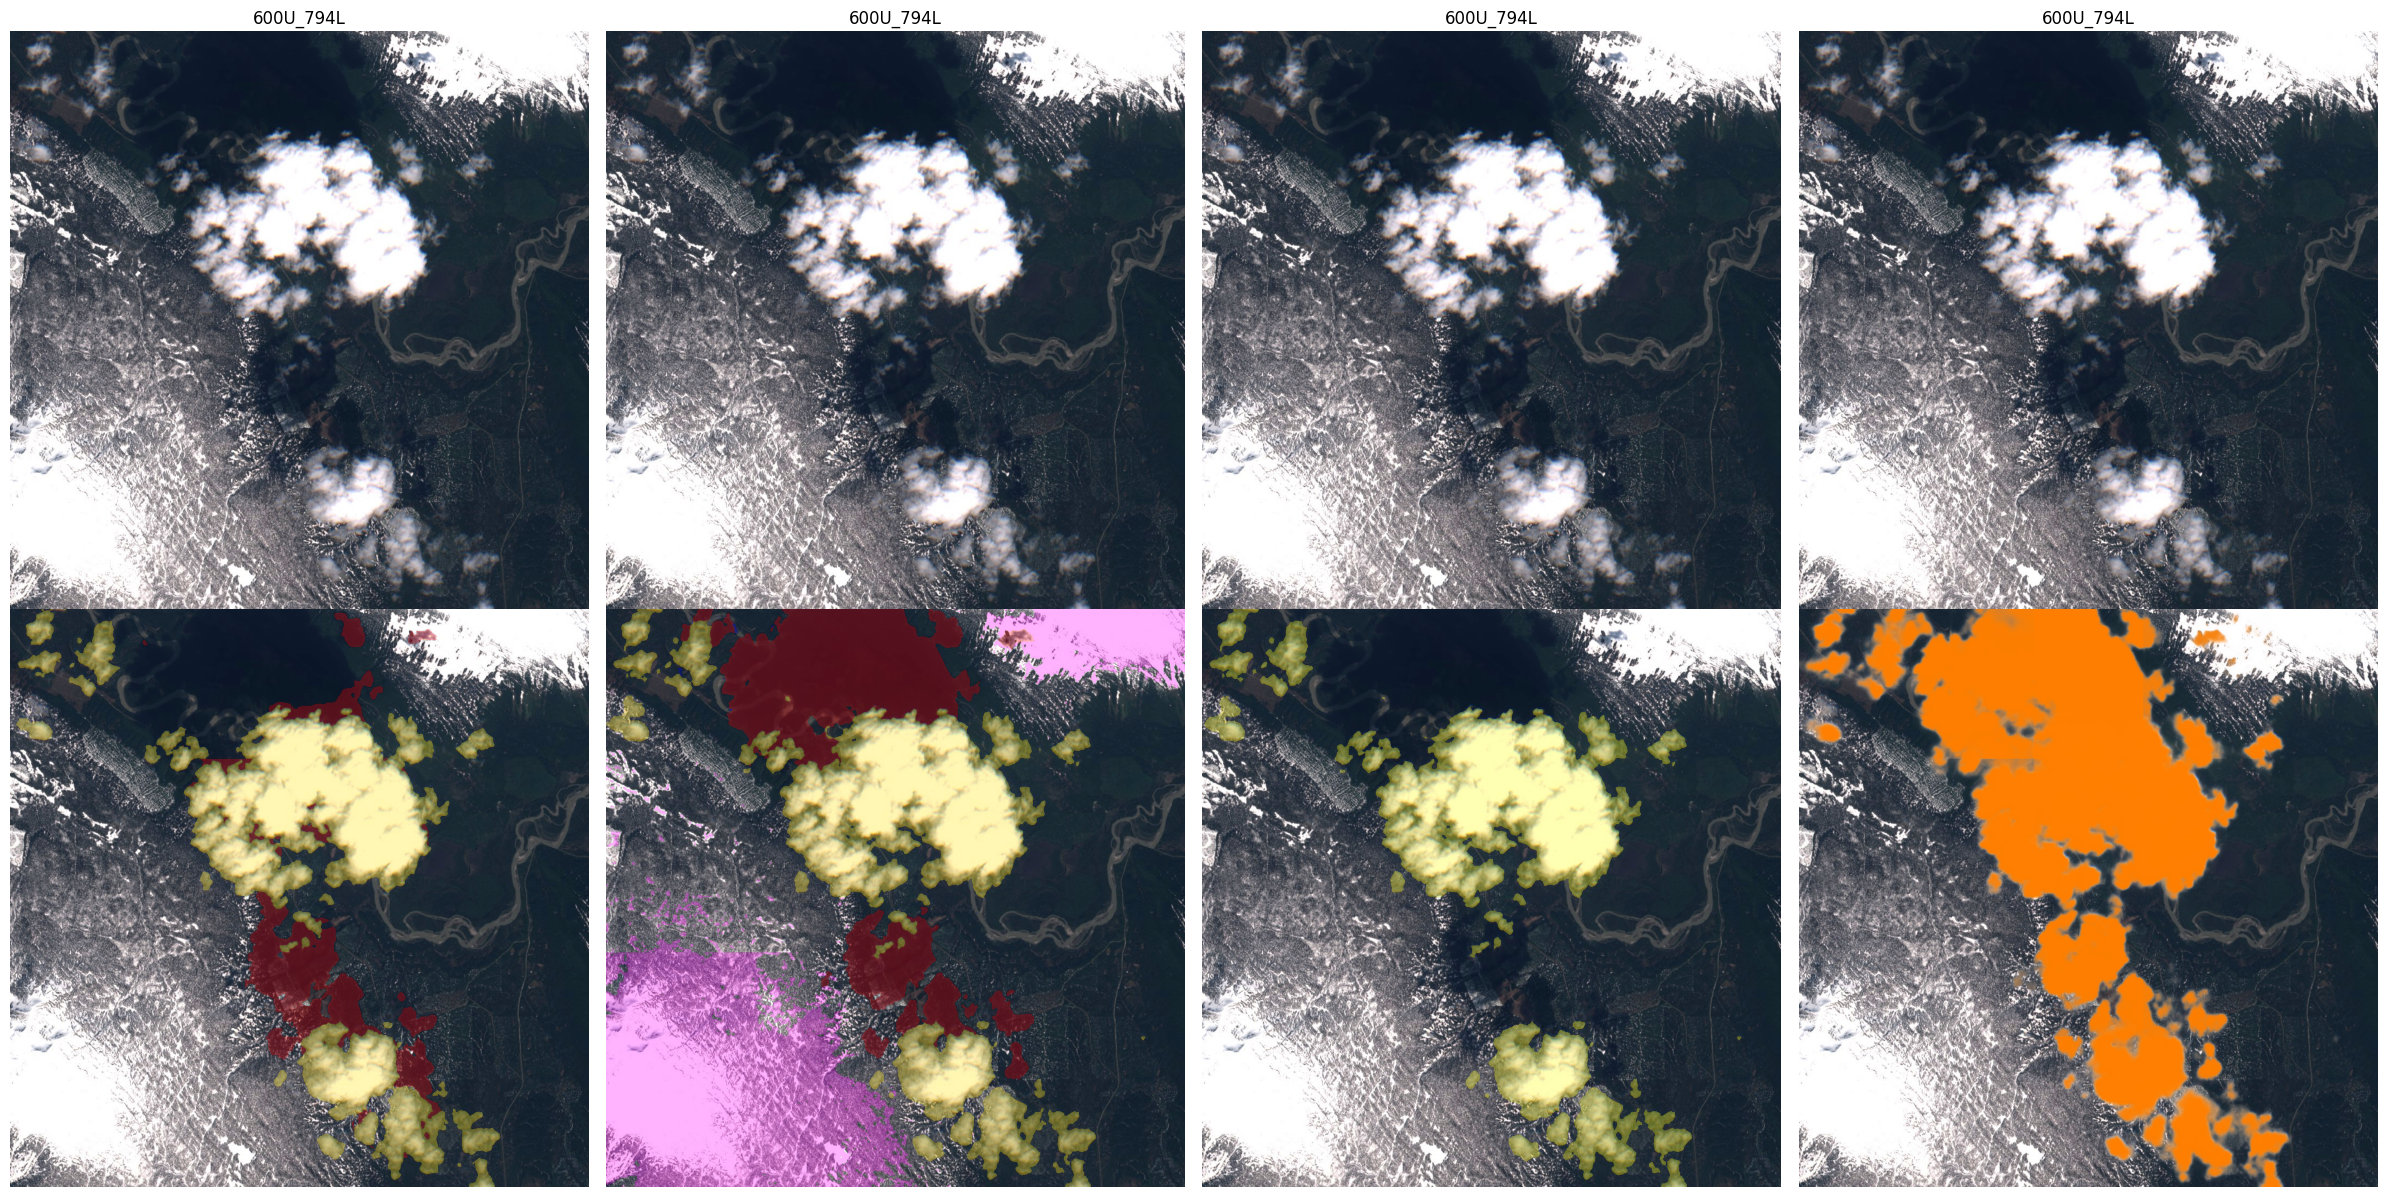

In [11]:
#@title Different settings

im = preprocess_majortom(ds[2],band_names)

print('Running with different settings (always same pretrained weights):')

print('\n1. Only RGB bands (B02,B03,B04) - we can use the same model class for this')
rgb_only = model(
  im[1:4],
  descriptors=SENTINEL2_DESCRIPTORS[1:4],
  stride=357
)
rgb_only = convert_to_colormap(rgb_only)

print('\n2. All bands, 7-class outputs - needs a new CloudMask object for different output style')
seven_class_model = CloudMask(
    config,
    weights,
    verbose=True,
    categorise=True,
    output_style=None,
    device=DEVICE,
)

seven_class = seven_class_model(
  im,
  descriptors=SENTINEL2_DESCRIPTORS,
  stride=357
)
seven_class = convert_to_colormap(seven_class,style='7-class')

print('\n3. cloud-noncloud outputs  - needs a new CloudMask object for different output style')
two_class_model = CloudMask(
    config,
    weights,
    verbose=True,
    categorise=True,
    output_style='cloud-noncloud',
    device=DEVICE,
)
two_class = two_class_model(
  im,
  descriptors=SENTINEL2_DESCRIPTORS,
  stride=357
)
two_class = convert_to_colormap(two_class,style='cloud-noncloud')

print('\n4. A few different input bands, valid-invalid classes, retaining original confidence values  - needs a new CloudMask object for different output style')
two_class_conf_model = CloudMask(
    config,
    weights,
    verbose=True,
    categorise=False,
    output_style='valid-invalid',
    device=DEVICE,
)
heatmap = two_class_conf_model(
  im[[0,4,8,10,12]],
  descriptors=[SENTINEL2_DESCRIPTORS[i] for i in [0,4,8,10,12]],
  stride=357
)
heatmap = 1-np.moveaxis(heatmap[[1,1,1,0],...],0,-1)*[[[0,0.5,1,1]]] # Convert to a simple colorscale

new_masks = [rgb_only,seven_class,two_class,heatmap]
new_ds = [ds[2]]*4

plot_masks(new_ds,new_masks,convert=False)